# Preparing the data for the MVD analysis
> # CRISP-DM Framework
> * Business Problem:   Reduce Motor Vehicle Deaths in the US using Socio Economic Data
> * Data Understanding: What the data set is
> * Data Preparation:   All Data Cleaning, inc treatment of missing Data, NaNs, zeros, transforms
> * Modelling:          The Modelling Workflow, models used and feature transforms / engineering
> * Evaulation:         Evaluation of the Final Model vs Baseline Model
> * Deployment:         Results generated by the model

In this notebook, we address the `Data Understanding` and the `Data Preparation` stages of the CRISP-DM.

## Data Understanding Summary
### Imports (data and libraries)

In [1]:
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import src.Petna as pt
matplotlib.rcParams['figure.figsize'] = (50,50)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 2000)
pd.set_option('display.max_rows', 2000)
%reload_ext autoreload
%autoreload 2

xls = pd.ExcelFile('src/2019 County Health Rankings Data - v2.xls')
sheets = xls.sheet_names
sheets

['Introduction',
 'Outcomes & Factors Rankings',
 'Outcomes & Factors SubRankings',
 'Ranked Measure Data',
 'Ranked Measure Sources & Years',
 'Additional Measure Data',
 'Addtl Measure Sources & Years']

### Missing data

('Unnamed: 0_level_0', 'FIPS') - 0% missing
('Unnamed: 1_level_0', 'State') - 0% missing
('Unnamed: 2_level_0', 'County') - 0% missing
('Life expectancy', 'Life Expectancy') - 2% missing
('Life expectancy', '95% CI - Low') - 2% missing
('Life expectancy', '95% CI - High') - 2% missing
('Life expectancy', 'Life Expectancy (Black)') - 57% missing
('Life expectancy', 'Life Expectancy (Hispanic)') - 60% missing
('Life expectancy', 'Life Expectancy (White)') - 45% missing
('Premature age-adjusted mortality', '# Deaths') - 2% missing
('Premature age-adjusted mortality', 'Age-Adjusted Mortality') - 2% missing
('Premature age-adjusted mortality', '95% CI - Low') - 2% missing
('Premature age-adjusted mortality', '95% CI - High') - 2% missing
('Premature age-adjusted mortality', 'Age-Adjusted Mortality (Black)') - 57% missing
('Premature age-adjusted mortality', 'Age-Adjusted Mortality (Hispanic)') - 73% missing
('Premature age-adjusted mortality', 'Age-Adjusted Mortality (White)') - 50% missing

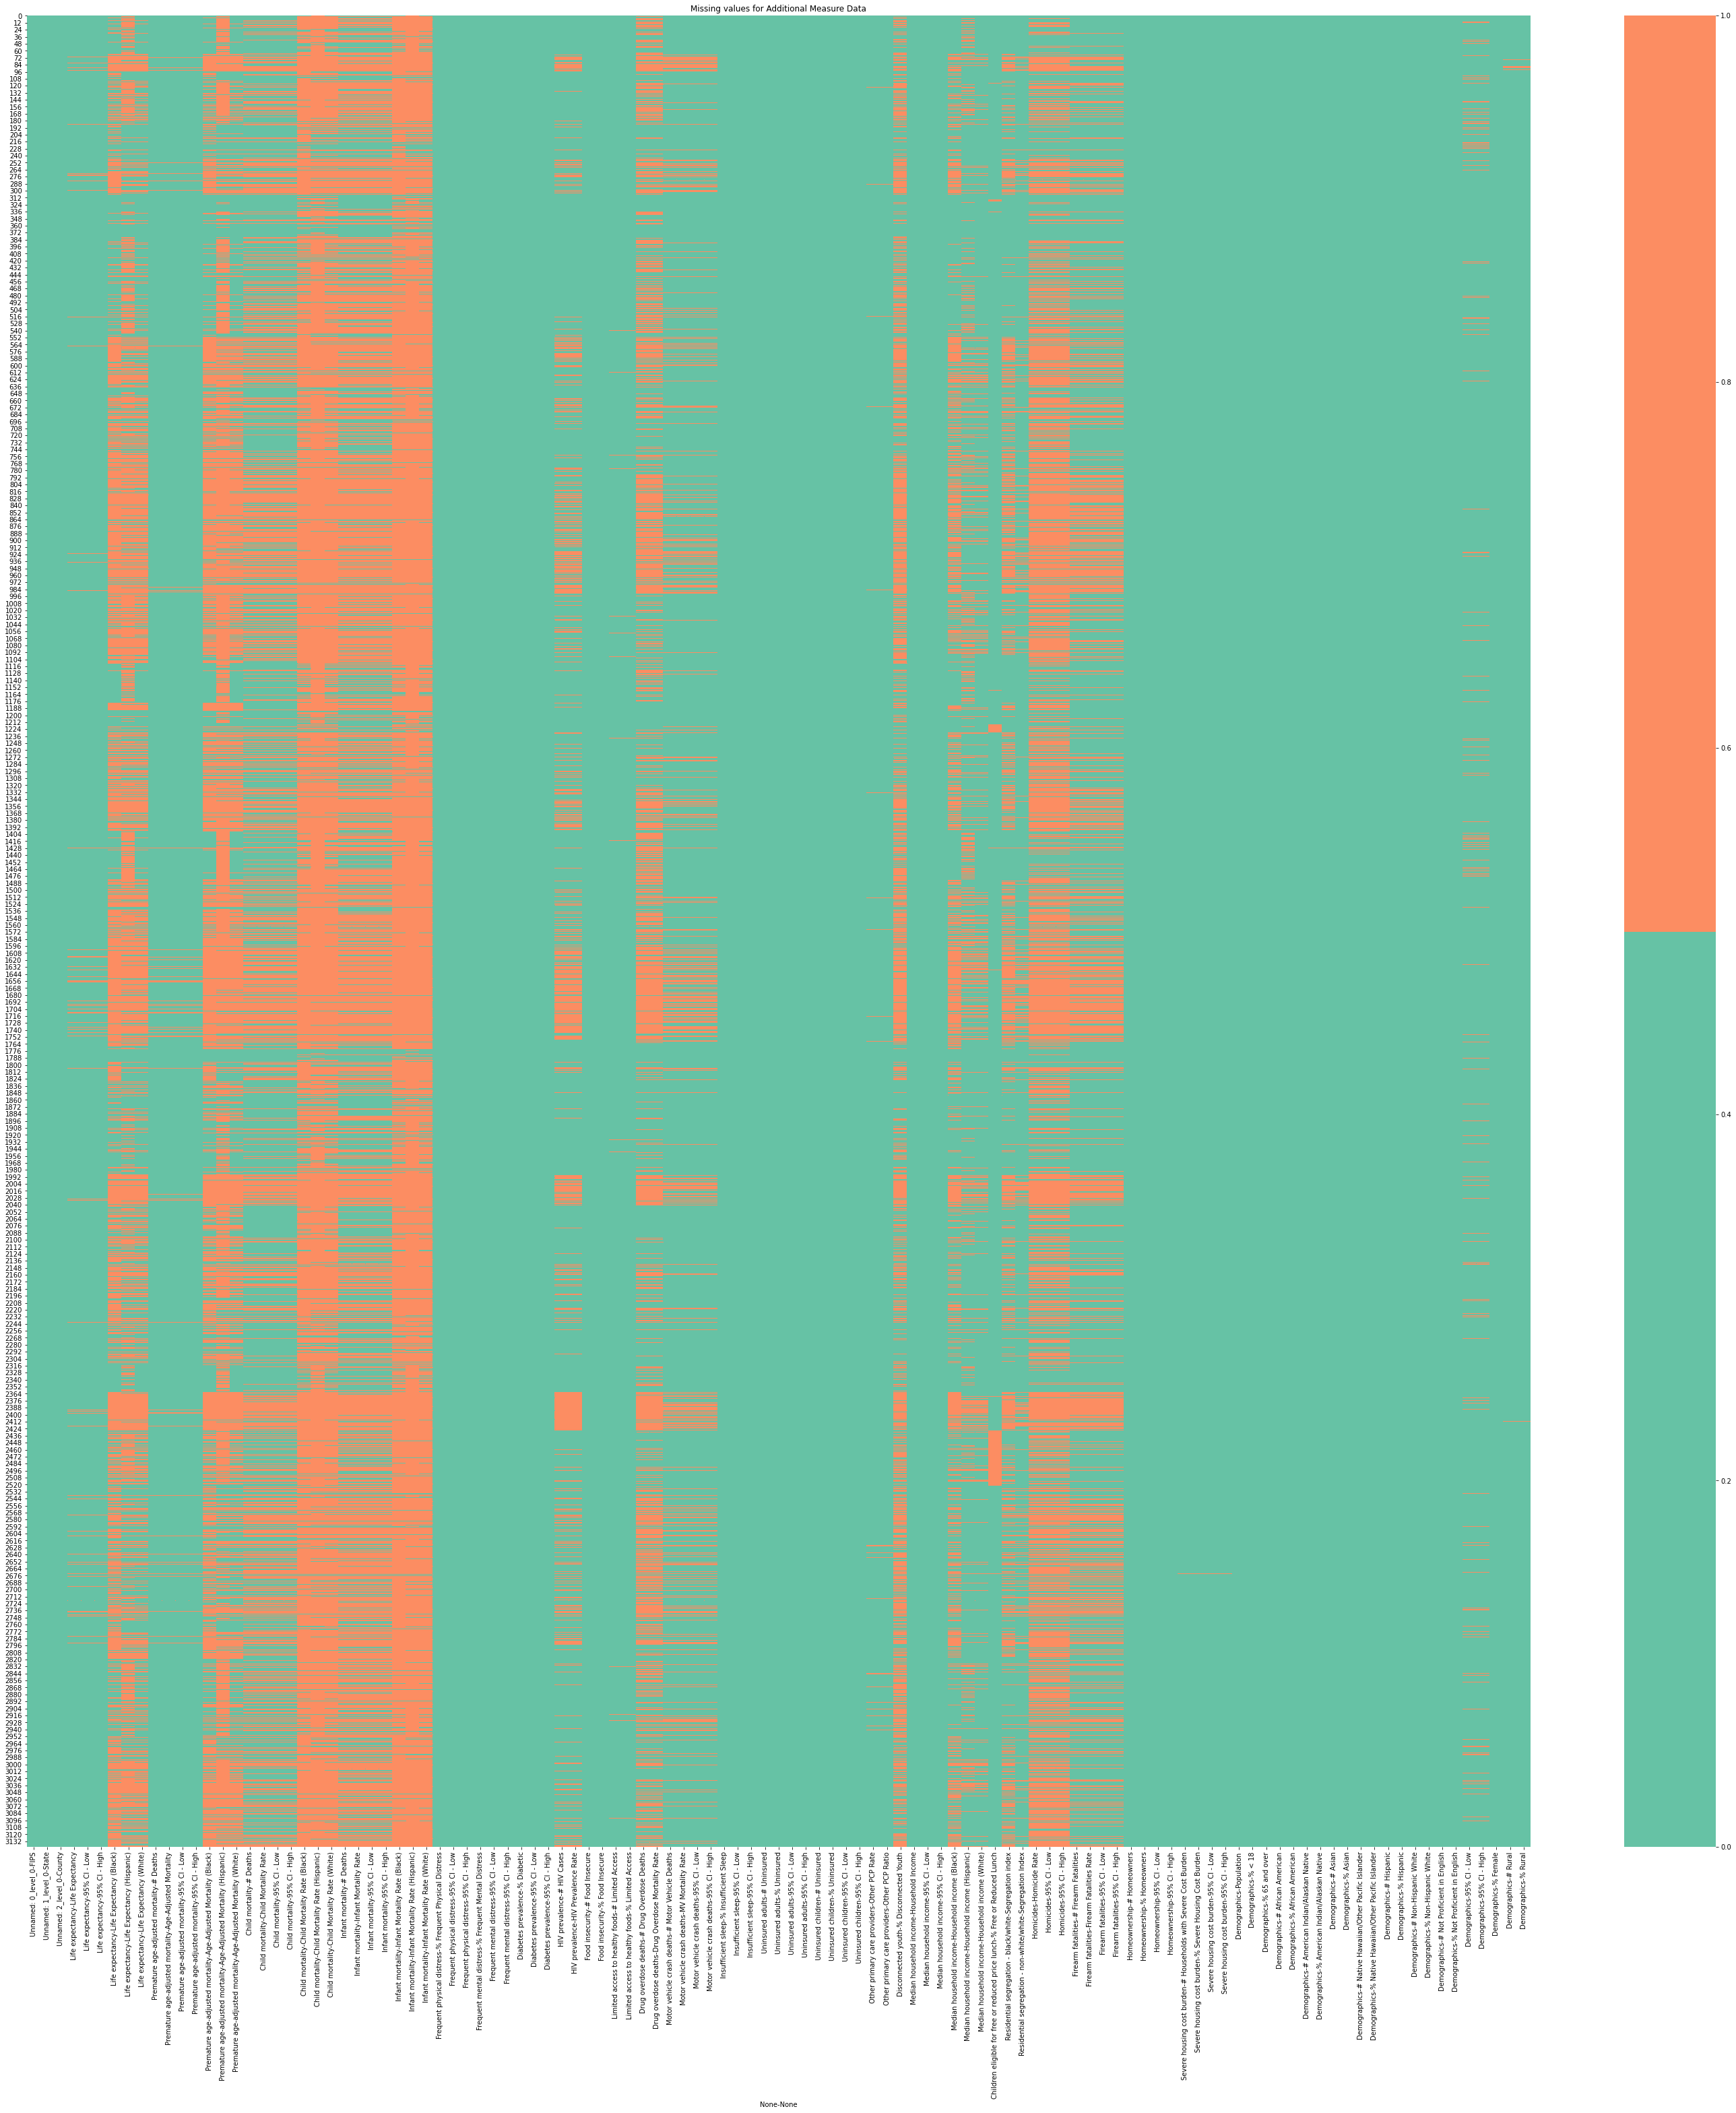

In [2]:
pt.missingvalues(sheets[5],xls)

### Generating the final dataset...
Aggreagating the sheets into a master table and getting rid of the columns we are not going to use during the analysis. We are going to percentages and rates instead of absolut values.

In [3]:
rmd = xls.parse(sheets[3],header=1)
amd = xls.parse(sheets[5],header=1)
amd = amd.drop(columns=['State','County'])
df = rmd.merge(amd, on='FIPS')

In [4]:
for kw in ['95%','Quartile','#','Unreliable']:
    df = df.drop(columns=[x for x in df.columns if kw in x])
df = df.set_index('FIPS')

In [5]:
subs = [(' ', '_'),('.',''),("'",""),('™', ''), ('®',''),
        ('+','plus'), ('½','half'), ('-','_'), ('<','under'), ('%','percent'), ('/', '_or_') 
       ]
def col_formatting(col):
    for old, new in subs:
        col = col.replace(old,new)
    return col

df.columns = [col_formatting(col) for col in df.columns]

### ... and addressing the missing values
#### MV_Mortality_Rate
Motor Vehicle related Deaths rate per 100,000 is our target variable.
The rate is calculated as Number of Motor Deaths / Population. In the survey number of motor vehicle deaths reported is over a seven year period 2011 - 2017. To convert this to an annual equivalent we have divided by 7.
For missing numbers we have applied the state average rate. Interestingly no single figure MV deaths were reported across the dataset.

In [6]:
df['MV_Mortality_Rate'] = df['MV_Mortality_Rate']/7
df['MV_Mortality_Rate'] = df['MV_Mortality_Rate'].fillna(df.groupby(by='State')['MV_Mortality_Rate'].transform('mean'))

#### Independent Variables
`Household_Income`, `%_Alcohol_Impaired_Car_Crashed`, `%_Rural`, `%_Uninsured` and `YPPL` $NaN$ values have been replaced by the state mean. 

`Average_Daily_PM25` Nan are replaced by 0 as only the whole of Alska and Hawai have $NaN$ values.

In [7]:
df['Average_Daily_PM25'] = df['Average_Daily_PM25'].fillna(0)
df['Household_Income'] = df['Household_Income'].fillna(df.groupby(by='State')['Household_Income'].transform('mean'))
df['percent_Alcohol_Impaired'] = df['percent_Alcohol_Impaired'].fillna(df.groupby(by='State')['percent_Alcohol_Impaired'].transform('mean'))
df['percent_Rural'] = df['percent_Rural'].fillna(df.groupby(by='State')['percent_Rural'].transform('mean'))
df['percent_Uninsured_x'] = df['percent_Uninsured_x'].fillna(df.groupby(by='State')['percent_Uninsured_x'].transform('mean'))
df['Years_of_Potential_Life_Lost_Rate'] = df['Years_of_Potential_Life_Lost_Rate'].fillna(df.groupby(by='State')['Years_of_Potential_Life_Lost_Rate'].transform('mean'))

In [8]:
df

,State,County,Years_of_Potential_Life_Lost_Rate,YPLL_Rate_(Black),YPLL_Rate_(Hispanic),YPLL_Rate_(White),percent_Fair_or_Poor,Physically_Unhealthy_Days,Mentally_Unhealthy_Days,percent_LBW,percent_LBW_(Black),percent_LBW_(Hispanic),percent_LBW_(White),percent_Smokers,percent_Obese,Food_Environment_Index,percent_Physically_Inactive,percent_With_Access,percent_Excessive_Drinking,percent_Alcohol_Impaired,Chlamydia_Rate,Teen_Birth_Rate,Teen_Birth_Rate_(Black),Teen_Birth_Rate_(Hispanic),Teen_Birth_Rate_(White),percent_Uninsured_x,PCP_Rate,PCP_Ratio,Dentist_Rate,Dentist_Ratio,MHP_Rate,MHP_Ratio,Preventable_Hosp_Rate,Preventable_Hosp_Rate_(Black),Preventable_Hosp_Rate_(Hispanic),Preventable_Hosp_Rate_(White),percent_Screened,percent_Screened_(Black),percent_Screened_(Hispanic),percent_Screened_(White),percent_Vaccinated,percent_Vaccinated_(Black),percent_Vaccinated_(Hispanic),percent_Vaccinated_(White),Cohort_Size,Graduation_Rate,Population_x,percent_Some_College,Labor_Force,percent_Unemployed,percent_Children_in_Poverty,percent_Children_in_Poverty_(Black),percent_Children_in_Poverty_(Hispanic),percent_Children_in_Poverty_(White),80th_Percentile_Income,20th_Percentile_Income,Income_Ratio,percent_Single_Parent_Households,Association_Rate,Annual_Average_Violent_Crimes,Violent_Crime_Rate,Injury_Death_Rate,Average_Daily_PM25,Presence_of_violation,percent_Severe_Housing_Problems,Severe_Housing_Cost_Burden,Overcrowding,Inadequate_Facilities,percent_Drive_Alone,percent_Drive_Alone_(Black),percent_Drive_Alone_(Hispanic),percent_Drive_Alone_(White),percent_Long_Commute___Drives_Alone,Life_Expectancy,Life_Expectancy_(Black),Life_Expectancy_(Hispanic),Life_Expectancy_(White),Age_Adjusted_Mortality,Age_Adjusted_Mortality_(Black),Age_Adjusted_Mortality_(Hispanic),Age_Adjusted_Mortality_(White),Child_Mortality_Rate,Child_Mortality_Rate_(Black),Child_Mortality_Rate_(Hispanic),Child_Mortality_Rate_(White),Infant_Mortality_Rate,Infant_Mortality_Rate_(Black),Infant_Mortality_Rate_(Hispanic),Infant_Mortality_Rate_(White),percent_Frequent_Physical_Distress,percent_Frequent_Mental_Distress,percent_Diabetic,HIV_Prevalence_Rate,percent_Food_Insecure,percent_Limited_Access,Drug_Overdose_Mortality_Rate,MV_Mortality_Rate,percent_Insufficient_Sleep,percent_Uninsured_y,percent_Uninsured1,Other_PCP_Rate,Other_PCP_Ratio,percent_Disconnected_Youth,Household_Income,Household_income_(Black),Household_income_(Hispanic),Household_income_(White),percent_Free_or_Reduced_Lunch,Segregation_index,Segregation_Index,Homicide_Rate,Firearm_Fatalities_Rate,percent_Homeowners,percent_Severe_Housing_Cost_Burden,Population_y,percent_under_18,percent_65_and_over,percent_African_American,percent_American_Indian_or_Alaskan_Native,percent_Asian,percent_Native_Hawaiian_or_Other_Pacific_Islander,percent_Hispanic,percent_Non_Hispanic_White,percent_Not_Proficient_in_English,percent_Female,percent_Rural
FIPS,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1001,Alabama,Autauga,8824.057123,10471.252986,NaN,8706.658832,18.411124,4.200578,4.306739,8.475719,12.620321,NaN,7.397260,19.124658,37.5,7.2,31.1,68.677503,16.878015,28.813559,341.2,26.524208,29.501526,26.809651,26.184918,8.500967,41.50426,2409:1,32.43010,3084:1,16.21505,6167:1,6599.0,11175.0,NaN,5909.0,44.0,45.0,27.0,44.0,41.0,32.0,36.0,42.0,660.0,90.000000,14298,60.854665,25909.0,3.863522,19.3,38.816023,15.953307,15.428034,105294,22709,4.636664,24.700097,12.631731,148.5,272.282220,74.031808,11.7,No,14.954646,13.205223,2.451581,0.637411,85.965057,82.722037,NaN,83.710021,38.3,76.330589,74.600628,NaN,76.337219,438.7,532.977595,NaN,432.175847,53.279441,92.748735,NaN,45.703839,7.699275,NaN,NaN,NaN,12.824434,12.638357,14.2,225.5,13.4,11.991125,9.623076,2.911023,35.905406,10.961104,2.476190,30.62842,3265:1,8.011653,58343.0,28595.0,89359.0,61380.0,47.931664,29.945393,27.147569,5.2,17.7,73.287736,12.645206,55504,23.937014,15.119631,19.254468,0.475641,1.279187,0.104497,2

In [9]:
df.to_csv('df.csv')

See you in [index.ipynb](./index.ipynb) for some statistical action!